In [15]:
import sys
print(sys.executable)
print(sys.version)


/Users/kim-yein/anaconda3/bin/python
3.11.3 (main, Apr 19 2023, 18:49:55) [Clang 14.0.6 ]


## 데이터 누수 의심되어 개선한 모델

### 기본 원칙

1. Scaler는 반드시 train 데이터로만 fit
- val/test는 transform만 적용
- 이유: val/test를 fit에 포함하면 미래 정보가 학습에 유출됨 → 데이터 누수

2. 시간 순서 유지
- train → val → test 순으로 분리
- 시계열은 shuffle X

# Feature Engineering
## 1. 데이터
- KRW-BTC_historical.csv 등 4개 종목의 코인
- 기간: 23.09.22~25.09.22
- 1시간 단위 호출 - 실제 거래가 발생한 시간에만 데이터 존재. 시간 간격이 일정하지 않음
- 목표: 1시간 후의 값 예측하기

In [1]:
import pandas as pd

files = ["KRW-BTC_historical.csv"]#, "KRW-ETH_historical.csv", "KRW-XRP_historical.csv", "KRW-DOGE_historical.csv"]
#dfs = []

for f in files:
    df = pd.read_csv(f"data/data_2023/{f}", parse_dates=['timestamp'])
    df = df.sort_values('timestamp')
    #dfs.append(df)

In [2]:
df.head()

,timestamp,market,trade_price,change_rate,acc_trade_volume
0,2023-09-22 00:00:00,KRW-BTC,36061000.0,0.000444,107.401450
1,2023-09-22 01:00:00,KRW-BTC,36045000.0,-0.001441,92.497331
2,2023-09-22 02:00:00,KRW-BTC,36097000.0,0.001832,29.542787
3,2023-09-22 03:00:00,KRW-BTC,36031000.0,0.000472,29.160949
4,2023-09-22 04:00:00,KRW-BTC,36014000.0,-0.001026,24.811768


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17537 entries, 0 to 17536
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         17537 non-null  datetime64[ns]
 1   market            17537 non-null  object        
 2   trade_price       17537 non-null  float64       
 3   change_rate       17536 non-null  float64       
 4   acc_trade_volume  17537 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 822.0+ KB


In [4]:
#결측치
#null과 누락된 시간대 보간
df = df.set_index('timestamp').resample('1H').ffill()

In [5]:
df.info()
#change_rate는 이전 시간 대비 가격 변화율이라서 1개가 null

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 2023-09-22 00:00:00 to 2025-09-22 23:00:00
Freq: H
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   market            17568 non-null  object 
 1   trade_price       17568 non-null  float64
 2   change_rate       17567 non-null  float64
 3   acc_trade_volume  17568 non-null  float64
dtypes: float64(3), object(1)
memory usage: 686.2+ KB


In [6]:
#시계열 특징 생성

#이동평균 (MA), 이동표준편차 (STD), RSI, MACD 등
#Lag feature 생성 (trade_price t-1, t-2 …)

df['MA_3'] = df['trade_price'].rolling(3).mean()
df['MA_6'] = df['trade_price'].rolling(6).mean()
df['lag_1'] = df['trade_price'].shift(1)
df = df.dropna()

In [7]:
#데이터 입출력
#과거 24시간의 데이터로 다음 1시간 가격 예측
sequence_length = 24

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, 0])
    return np.array(X), np.array(y)

import numpy as np
features = df[['trade_price','acc_trade_volume','MA_3','MA_6','lag_1']].values
X, y = create_sequences(features, sequence_length)


In [8]:
#학습/검증/테스트(7:2:1) 데이터 분리
#시계열 데이터이므로 시간 순서대로 split
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.2)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

In [9]:
X_train.shape[2]

5

In [10]:
#정규화
#train-fit, val/test-transform
from sklearn.preprocessing import MinMaxScaler
import numpy as np

num_features = X_train.shape[2]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, num_features)).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape)

scaler_y = MinMaxScaler()

# 반드시 2D 형태로 넣기: (samples, 1)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [11]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled), epochs=50, batch_size=32)


Epoch 1/50
384/384 [==============================] - 3s 6ms/step - loss: 0.0030 - val_loss: 1.3150e-04
Epoch 2/50
384/384 [==============================] - 2s 5ms/step - loss: 7.0803e-05 - val_loss: 1.3826e-04
Epoch 3/50
384/384 [==============================] - 2s 6ms/step - loss: 6.6401e-05 - val_loss: 1.5248e-04
Epoch 4/50
384/384 [==============================] - 2s 6ms/step - loss: 6.1791e-05 - val_loss: 1.0305e-04
Epoch 5/50
384/384 [==============================] - 2s 6ms/step - loss: 5.9590e-05 - val_loss: 1.0440e-04
Epoch 6/50
384/384 [==============================] - 2s 5ms/step - loss: 5.7705e-05 - val_loss: 8.1117e-05
Epoch 7/50
384/384 [==============================] - 2s 5ms/step - loss: 5.5891e-05 - val_loss: 1.4793e-04
Epoch 8/50
384/384 [==============================] - 3s 8ms/step - loss: 5.4841e-05 - val_loss: 8.8946e-05
Epoch 9/50
384/384 [==============================] - 2s 5ms/step - loss: 4.7478e-05 - val_loss: 8.4224e-05
Epoch 10/50
384/384 [===========

In [12]:
#모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error
y_pred = model.predict(X_test_scaled)
print(y_pred.shape)
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
mae = mean_absolute_error(y_test_scaled, y_pred)
print("RMSE:", rmse, "MAE:", mae)

55/55 [==============================] - 0s 2ms/step
(1755, 1)
RMSE: 0.005857838118325846 MAE: 0.0050722022812521705


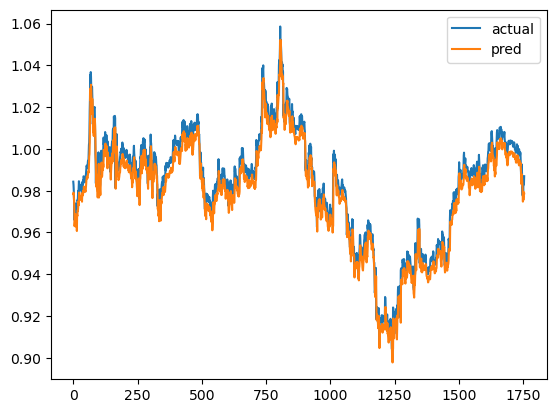

In [13]:
#시각화
import matplotlib.pyplot as plt
plt.plot(y_test_scaled, label='actual')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

### MinMaxScaling 후 
- RMSE < 0.01 이면 성능 좋은 편
- MAE  < 0.01~2 이면 정확한 편

# 모델 저장

In [14]:
import os
import json
from tensorflow.keras.models import load_model
from joblib import dump

# artifacts 폴더 생성
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# === 모델 저장 ===
model.save(os.path.join(ARTIFACT_DIR, "lstm_model.h5"))

# === 스케일러 저장 ===
dump(scaler_X, os.path.join(ARTIFACT_DIR, "scaler_X.joblib"))
dump(scaler_y, os.path.join(ARTIFACT_DIR, "scaler_y.joblib"))

# === 피처 리스트 저장 ===
features = ['trade_price','acc_trade_volume','MA_3','MA_6','lag_1']
with open(os.path.join(ARTIFACT_DIR, "features.json"), "w") as f:
    json.dump(features, f)

/Users/kim-yein/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 시계열 특징 변수 추가
1. 최소한의 핵심 피처로 베이스라인 학습(현재)
- trade_price, acc_trade_volume, lag_1, MA_3 정도
- 모델이 정상적으로 학습되는지 확인

2. 추가 feature 생성
- 변동성, momentum, 거래량 변화, 시간 관련 정보 등
- 모델 학습 후 성능 향상 여부 확인

3. 중요 피처 선별
- Permutation importance 또는 SHAP 값으로 feature importance 확인
- 중요하지 않은 피처 제거 후 모델 재학습 → 성능 안정화

## 추가 고도화
1. 다중 종목 모델
- BTC, ETH, XRP, DOGE 데이터를 함께 학습
- Cross-correlation 반영 가능

2. 다중 단계 예측
- 다음 1시간뿐 아니라 6시간, 12시간 등도 예측

3. 강화학습/Transformer
- Transformer 기반 시계열 모델 (예: Informer, Temporal Fusion Transformer)
- 더 긴 시퀀스 학습 가능

4. 자동화
- 실시간 가격 데이터 수집 → 모델 예측 → 알람/트레이딩 전략 적용